# Data Analysis for Software Engineers

## Practical Assignment 5
## Ensemble Learning

<hr\>
**General Information**

**Due date:** 20 May 2018, 23:59 <br\>
**Submission link:** [here](https://www.dropbox.com/request/8ZfcRf2dAiGPAH8nL8Zy)

Add your name to this notebook's title<br\>
<hr\>

Take in to account that some tasks may not have rigorous and comprehensive solution.<br\>
Support your code with comments and illustation if needed. The more conclusions, derivations and explanations you provide - the better. <br\>


In [171]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomTreesEmbedding
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from random import seed

%matplotlib inline

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12,8)

# Prepare dataset (1 point)

During this task we are going to check some ensemble models on California Housing Dataset. This is going to be regression task, so error metric is set to **RMSE**.

Load `housing.csv` dataset. 

You are going to work mostly with tree-based models, so:
* No feature normalization is required 
* Categorical feature "`ocean_proximity`" should be encoded either with labels `(0, 1, 2, 3, 4)` or with OHE.
* Features with missing values should be filled with extraordinary values
* Target column is "`median_house_value`"

As a result you should get `np.array` "`y`" with target feature and `np.array` "`X`" with other features.

In [2]:
df = pd.read_csv('housing.csv')

In [3]:
df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [4]:
le = LabelEncoder()
le.fit(df['ocean_proximity'].unique())
df['ocean_proximity'] = le.transform(df['ocean_proximity'])

In [5]:
df['ocean_proximity'].unique()

array([3, 0, 1, 4, 2])

In [6]:
df.isna().describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
count,20640,20640,20640,20640,20640,20640,20640,20640,20640,20640
unique,1,1,1,1,2,1,1,1,1,1
top,False,False,False,False,False,False,False,False,False,False
freq,20640,20640,20640,20640,20433,20640,20640,20640,20640,20640


Видим, что в `total_bedrooms` есть NaN значения. Ну я их и заполнил медианными.

In [7]:
df['total_bedrooms'] = df['total_bedrooms'].fillna(df['total_bedrooms'].median())

In [8]:
df.isna().describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
count,20640,20640,20640,20640,20640,20640,20640,20640,20640,20640
unique,1,1,1,1,1,1,1,1,1,1
top,False,False,False,False,False,False,False,False,False,False
freq,20640,20640,20640,20640,20640,20640,20640,20640,20640,20640


In [238]:
y = np.array(df['median_house_value'])
X = np.array(df.drop(['median_house_value'], axis=1))

In [241]:
df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,3
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,3
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,3
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,3
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,3


## Split to train and validation sets
Choose arbitrary `random_seed` and split you data to train and validation parts in proportion 80/20.

As a result you should get `X_train`, `X_valid`, `y_train` and `y_valid`

In [10]:
RANDOM_SEED = 4118956
seed(RANDOM_SEED)

In [11]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, random_state=RANDOM_SEED)

# Random Forest Model (3 points)

Implement function `learn_rf(...)`

**Inputs:**
`X_train`, `y_train`, `X_valid`, `y_valid`, `num_trees`

**Outputs:**
* `importance` - `np.array` with feature importances
* `pred_train` - `np.array` with predictions of RF on train set
* `pred_train_ind` - `np.array` with predictions of each individual trees on train set
* `pred_valid` - `np.array` with predictions of RF on validation set
* `pred_valid_ind` - `np.array` with predictions of each individual trees on validation set

Train Random Forest Regression models with 10, 20, 30, 50, 100 and 200 trees.

* Show feature names and their importance (at any number of trees)
* For every random forest model compare train- and validation- errors’ variance of individual trees and ensemble model. Explain your observations.

In [111]:
def learn_rf(X_train, y_train, X_valid, y_valid, num_trees):
    rf = RandomForestRegressor(random_state=RANDOM_SEED, n_estimators=num_trees)
    rf.fit(X_train, y_train)
    return {
        'importance': rf.feature_importances_,
        'pred_train': rf.predict(X_train),
        'pred_train_ind': np.array(map(lambda tree: tree.predict(X_train), rf.estimators_)),
        'pred_valid': rf.predict(X_valid),
        'pred_valid_ind': np.array(map(lambda tree: tree.predict(X_valid), rf.estimators_))
    }

In [112]:
results = []
trees = [10, 20, 30, 50, 100, 200]
for t in trees:
    results.append(learn_rf(X_train, y_train, X_valid, y_valid, t))

In [113]:
cols = list(df.drop(['median_house_value'], axis=1).columns)

In [114]:
f_importances = []
for i in range(len(trees)):
    f_importances.append({
        'num_trees': trees[i],
        'props': dict(zip(cols, results[0]['importance'].astype(bool)))
    })

In [115]:
f_importances

[{'num_trees': 10,
  'props': {'households': True,
   'housing_median_age': True,
   'latitude': True,
   'longitude': True,
   'median_income': True,
   'ocean_proximity': True,
   'population': True,
   'total_bedrooms': True,
   'total_rooms': True}},
 {'num_trees': 20,
  'props': {'households': True,
   'housing_median_age': True,
   'latitude': True,
   'longitude': True,
   'median_income': True,
   'ocean_proximity': True,
   'population': True,
   'total_bedrooms': True,
   'total_rooms': True}},
 {'num_trees': 30,
  'props': {'households': True,
   'housing_median_age': True,
   'latitude': True,
   'longitude': True,
   'median_income': True,
   'ocean_proximity': True,
   'population': True,
   'total_bedrooms': True,
   'total_rooms': True}},
 {'num_trees': 50,
  'props': {'households': True,
   'housing_median_age': True,
   'latitude': True,
   'longitude': True,
   'median_income': True,
   'ocean_proximity': True,
   'population': True,
   'total_bedrooms': True,
   'to

Видим, что `True` значение принимает только `median_income`

In [116]:
valid_metric = []
train_metric = []

for i in results:
    valid_metric.append(mean_squared_error(y_valid, i['pred_valid'], multioutput='raw_values'))
    train_metric.append(mean_squared_error(y_train, i['pred_train'], multioutput='raw_values'))

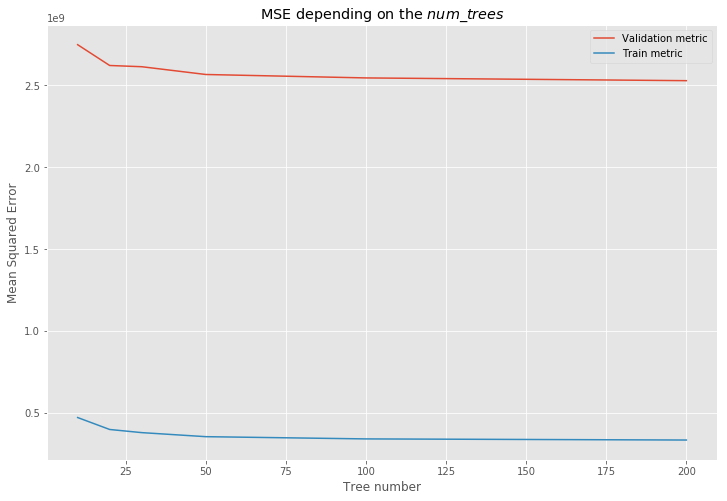

In [119]:
plt.plot(trees, valid_metric, label='Validation metric');
plt.plot(trees, train_metric, label='Train metric');
plt.title('MSE depending on the $num\_trees$')
plt.xlabel('Tree number')
plt.ylabel('Mean Squared Error')
plt.legend()
plt.show();

На валидационной выборке ошибки более высокие. Это связано 

# Gradient Boosing Model (3 points)

Implement function `learn_gbm(...)`

**Inputs:**
`X_train`, `y_train`, `X_valid`, `y_valid`, `num_stages`, `learning_rate`.

**Outputs:**
* `importance` - `np.array` with feature importances
* `pred_train` - `np.array` with **final** predictions of GBM on train set
* `pred_train_staged` - `np.array` with **staged** predictions on train set (after each new tree)
* `pred_valid` - `np.array` with **final** predictions of GBM on validation set
* `pred_valid_staged` - `np.array` with **staged** predictions on validation set (after each new tree) 

Useful functions and classes: `GradientBoostingRegressor.staged_predict()`

You are highly encouraged to use advanced libraries of gradient boosting instead of sklearn implementation, like [XGBoost](https://github.com/dmlc/xgboost), [CatBoost](https://github.com/catboost/catboost) or [LightGBM](https://github.com/Microsoft/LightGBM). 

So pick one, make sure you have installed the last version, and use it in this task.

Use `learn_gbt` function to train Gradient Boosting Tree Regression model with `1000` trees 

* Try to pick 3 values of  `learning_rate` for 
    * Aggresive learning - error on train set is getting low, but validation error decreases only on first steps and goes up afterwards
    * Slow learning - error on train and validation sets is getting low VERY slowly
    * Healthy learning - error on train and validation sets is getting low and optimal number of iterations (where validation error (almost) stops decreasing) is somewhere between 800 and 1000.
* Show feature names and importance (for the latter `learning_rate` value). Are importances different  from Random Forest case? Why?

In [140]:
def learn_gbm(X_train, y_train, X_valid, y_valid, num_stages, learning_rate):
    gbr = GradientBoostingRegressor(random_state=RANDOM_SEED, n_estimators=num_stages, learning_rate=learning_rate)
    gbr.fit(X_train, y_train)
    return {
        'importance': gbr.feature_importances_,
        'pred_train': gbr.predict(X_train),
        'pred_train_staged': [x for x in gbr.staged_predict(X_train)],
        'pred_valid': gbr.predict(X_valid),
        'pred_valid_staged': [x for x in gbr.staged_predict(X_valid)]
    }

In [153]:
learning_rates = [0.01, 0.001, 0.0001]

In [154]:
results = []

for lr in learning_rates:
    results.append(learn_gbm(X_train, y_train, X_valid, y_valid, num_stages=1000, learning_rate=lr))

In [156]:
f_importances = []
for i in range(len(learning_rates)):
    f_importances.append({
        'learning_rate': learning_rates[i],
        'props': dict(zip(cols, results[0]['importance'].astype(bool)))
    })

In [157]:
f_importances

[{'learning_rate': 0.01,
  'props': {'households': True,
   'housing_median_age': True,
   'latitude': True,
   'longitude': True,
   'median_income': True,
   'ocean_proximity': True,
   'population': True,
   'total_bedrooms': True,
   'total_rooms': True}},
 {'learning_rate': 0.001,
  'props': {'households': True,
   'housing_median_age': True,
   'latitude': True,
   'longitude': True,
   'median_income': True,
   'ocean_proximity': True,
   'population': True,
   'total_bedrooms': True,
   'total_rooms': True}},
 {'learning_rate': 0.0001,
  'props': {'households': True,
   'housing_median_age': True,
   'latitude': True,
   'longitude': True,
   'median_income': True,
   'ocean_proximity': True,
   'population': True,
   'total_bedrooms': True,
   'total_rooms': True}}]

Видим, что все фичи important

In [158]:
valid_metric = []
train_metric = []

for i in results:
    valid_metric.append(mean_squared_error(y_valid, i['pred_valid'], multioutput='raw_values'))
    train_metric.append(mean_squared_error(y_train, i['pred_train'], multioutput='raw_values'))

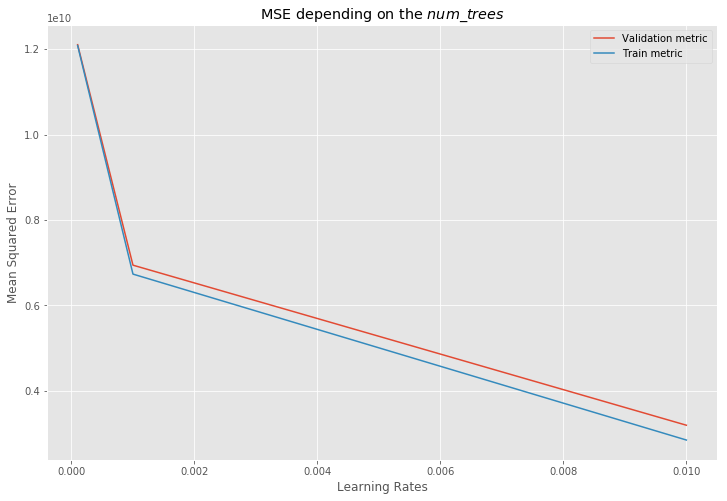

In [163]:
plt.plot(learning_rates, valid_metric, label='Validation metric');
plt.plot(learning_rates, train_metric, label='Train metric');
plt.title('MSE depending on the $num\_trees$')
plt.xlabel('Learning Rates')
plt.ylabel('Mean Squared Error')
plt.legend()
plt.show();

# Linear Regression with Random Trees Embedding (3 points)

Set baseline pipeline with the following steps:

* FeatureUnion of:
    * OneHotEncoding of categorical features
    * StandartScaling of other features
* Linear Regression

Fit on (`X_train`, `y_train`) and predict on (`X_valid`, `y_valid`) - you should get `pred_valid_base`.

In [175]:
pipeline = Pipeline([
#     ('ohe', OneHotEncoder()),
    ('ss', StandardScaler()),
    ('lr', LinearRegression()),
])

In [177]:
pipeline.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('ss', StandardScaler(copy=True, with_mean=True, with_std=True)), ('lr', LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False))])

In [180]:
pred_valid_base = pipeline.predict(X_valid)

Implement function `learn_lm(...)` which will learn the following pipeline:
* RandomTreesEmbedding
* LinearRegression

**Inputs:**
`X_train`, `y_train`, `X_valid`, `y_valid`, `num_trees`, `max_depth`.

**Outputs:**
* `pred_valid` - `np.array` with predictions on validation set

Useful functions and classes: [RandomTreesEmbedding](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomTreesEmbedding.html#sklearn.ensemble.RandomTreesEmbedding)

Run it with various `max_depth` and `num_trees`. Compare this pipeline with base pipeline on validation set as RMSE(this_pipeline)/RMSE(base_pipeline).

In [236]:
RandomTreesEmbedding(sparse_output=False).fit_transform(X_train).shape

(15480, 253)

In [237]:
X_train.shape

(15480, 9)

In [249]:
def learn_lm(X_train, y_train, X_valid, y_valid, num_trees, max_depth):
    transformed_train = RandomTreesEmbedding().fit_transform(X_train)
    transformed_valid = RandomTreesEmbedding().fit_transform(X_valid)
    lr = LinearRegression()
    lr.fit(X_train, y_train)
    print(lr.predict(X_valid))
    print(mean_squared_error(lr.predict(X_valid), y_valid))
#     print(transformed_train.shape)
#     print(transformed_valid.shape)

In [250]:
learn_lm(X_train, y_train, X_valid, y_valid, num_trees=1, max_depth=1)

[158312.79678394 248353.13401111 234652.17633013 ... 232972.14327832
 314663.90260727 238754.61452308]
5009159497.588298
